In [1]:
import os
import sys

chrome_driver_path = os.path.join("/", 'usr', 'local', 'bin', 'chromedriver')
app_path = os.path.join("/", 'usr', 'local', 'bin', 'chromedriver')
os.environ["PATH"] += os.pathsep + app_path
os.environ["MINIWOB_BASE_URL"] = "file:///Users/a18401417/work//miniwob-plusplus/html/"

In [2]:
from miniwob.environment import MiniWoBEnvironment
from miniwob.screenshot import pil_to_numpy_array
task_name = 'click-button'
base_url = os.environ.get('MINIWOB_BASE_URL')
env = MiniWoBEnvironment(task_name, seeds=[1], base_url=base_url)
print('BASE URL:', base_url)

BASE URL: file:///Users/a18401417/work//miniwob-plusplus/html/


In [3]:
env

In [4]:
states = env.reset(record_screenshots=True)

In [5]:
states

[MiniWoBState(utterance: 'Click on the "Ok" button.')]

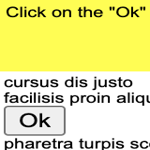

In [6]:
states[0].screenshot.resize([150, 150])

In [7]:
img = pil_to_numpy_array(states[0].screenshot)

In [8]:
img.shape

(210, 160, 3)

In [9]:
states[0].dom.visualize()

"- [1] body @ (0, 0) classes=[NO_CLASS] children=1\n  |- [2] div @ (0, 0) classes=[NO_CLASS] children=1\n     |- [3] div @ (0, 50) classes=[NO_CLASS] children=6\n        |- [4] div @ (2, 52) text='cursus dis justo' classes=[NO_CLASS]\n        |- [5] div @ (2, 63) text='facilisis proin aliq...' classes=[NO_CLASS]\n        |- [6] button @ (2, 74) text='Ok' classes=[NO_CLASS]\n        |- [7] div @ (2, 95) text='pharetra turpis scel...' classes=[NO_CLASS]\n        |- [8] div @ (2, 106) text='rutrum lectus adipis...' classes=[NO_CLASS]\n        |- [9] div @ (2, 117) text='pretium, aliquet ege...' classes=[NO_CLASS]"

In [10]:
states[0].tokens

['Click', 'on', 'the', '"', 'Ok', '"', 'button', '.']

In [11]:
states[0].dom.children[0].children[0].children[0]

[4] div @ (2, 52) text='cursus dis justo' classes=[NO_CLASS]

# Try actions

In [12]:
from miniwob.action import MiniWoBElementClick, MiniWoBCoordClick

In [13]:
states = env.reset()
states[0].tokens

['Click', 'on', 'the', '"', 'Okay', '"', 'button', '.']

In [14]:
env.step([MiniWoBCoordClick(10, 57)])

([MiniWoBState(utterance: 'Click on the "Okay" button.')],
 [0.0],
 [False],
 {'n': [{'done': False,
    'env_reward': 0,
    'raw_reward': 0,
    'reason': None,
    'elapsed': 0.32105112075805664}]})

# Gym miniwob wrapper

In [15]:
import gym
import torch

from miniwob.action import MiniWoBElementClick, MiniWoBCoordClick
from transformers import BertTokenizer, BertModel, BertConfig

class MiniWobClickButtonWrapper(gym.Wrapper):
    
    def __init__(self, env):      
        super().__init__(env)
        self.env = env
        bert_model = 'bert-base-cased'
        self.tokenizer = BertTokenizer.from_pretrained(bert_model)
        
        self.observation_space = gym.spaces.Dict({"goal_state": gym.spaces.Box(0, 
                                                                              self.tokenizer.vocab_size, (8, ),
                                                                              dtype=np.int64), 
                                                "state": gym.spaces.Box(0, 255, (150, 150, 3), dtype=np.uint8)})
        

        self.action_space = gym.spaces.Box(low=0, high=200, shape=(2, ), dtype=np.int32)

    def observation(self, obs):
        goal = self.tokenizer(obs.tokens,  padding='max_length', 
                       max_length = 8, truncation=True,          
                       return_tensors="pt",
                       is_split_into_words=True)['input_ids']
        img = torch.tensor(pil_to_numpy_array(obs.screenshot.resize([150, 150]))).unsqueeze(0)
        dom = obs.dom.visualize()
        return {'state': img, 'dom': dom, 'goal_state': goal}
    
    def reset(self):
        return self.observation(self.env.reset(record_screenshots=True)[0])
    
    def step(self, action):
        
        if type(action) == np.ndarray:
            action = np.abs(action + 1).astype(int)
            miniwob_action = [MiniWoBCoordClick(*tuple(action))]
        else:
            miniwob_action = [MiniWoBCoordClick(*tuple(action.numpy()[0, :]))]
        obs, reward, done, info = env.step(miniwob_action)
        if done[0]:
            return None, reward[0], done[0], info
        else:
            return self.observation(obs[0]), reward[0], done[0], info

In [16]:
import numpy as np

env = MiniWoBEnvironment(task_name, seeds=[1], base_url=base_url)
click_button_env = MiniWobClickButtonWrapper(env)
click_button_env.reset()

done = False
while not done:
    action = np.random.randint(200, size=2)
    state, reward, done, info =  click_button_env.step(action)
    print(reward)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.08360000000000001


# Bert encoder

In [17]:
from transformers import BertTokenizer, BertModel, BertConfig
from torch import nn
import torch

class BertEncoder(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        bert_model = 'bert-base-cased'
        
        self.bert_encoder = BertModel.from_pretrained(bert_model)
        self.embed_dim = 768
        self.output_size = 100
        self.lstm = nn.LSTM(input_size=self.embed_dim, 
                            hidden_size=self.output_size, 
                            num_layers=2)
        
   
    def forward(self, input_ids):
        """
        Encode batch of tokens
        
        """
#         input_ids = self.tokenizer(goals,  padding='max_length', 
#                       max_length = 8, truncation=True,          
#                       return_tensors="pt",
#                       is_split_into_words=True)['input_ids']
        
        with torch.no_grad():
            embeds = self.bert_encoder(input_ids).last_hidden_state
        embeds = embeds.permute([1, 0, 2])
            
        output, _ = self.lstm(embeds)
        return output[-1]

# Train agent

In [18]:
from rllr.models.encoders import GoalStateEncoder, SimpleCNN

conf = {
    "n_channels": [32, 64, 64],
    "kernel_sizes": [4, 4, 3],
    "strides": [4, 2, 1],
    "hidden_layers_sizes": [128]
}

state_encoder = SimpleCNN(grid_size=150, conf=conf)
goal_encoder = BertEncoder()
encoder = GoalStateEncoder(state_encoder, goal_encoder)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
import numpy as np
env = MiniWoBEnvironment(task_name, seeds=[1], base_url=base_url)
click_button_env = MiniWobClickButtonWrapper(env)
click_button_env.reset()

done = False
action = torch.from_numpy(np.random.randint(200, size=(1, 2)))
state, reward, done, info =  click_button_env.step(action)

In [20]:
encoder.forward(state)

tensor([[ 0.0000,  0.0292,  0.0292,  0.0000,  0.0031,  0.0000,  0.0000,  0.0479,
          0.0000,  0.0000,  0.1049,  0.0000,  0.0000,  0.0194,  0.0000,  0.0000,
          0.0513,  0.0054,  0.0000,  0.0000,  0.0000,  0.0351,  0.0000,  0.0000,
          0.0000,  0.0147,  0.0000,  0.0731,  0.0000,  0.0000,  0.0721,  0.0000,
          0.0036,  0.0165,  0.0000,  0.0000,  0.0058,  0.0402,  0.0000,  0.0000,
          0.0400,  0.0000,  0.0000,  0.0041,  0.0000,  0.0036,  0.0000,  0.0000,
          0.0000,  0.0673,  0.0000,  0.0533,  0.0000,  0.0116,  0.0000,  0.0000,
          0.0288,  0.0000,  0.0231,  0.0000,  0.0000,  0.0000,  0.0000,  0.0146,
          0.0717,  0.0000,  0.0764,  0.0228,  0.0424,  0.0000,  0.0457,  0.0050,
          0.0712,  0.0605,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0276,  0.0219,  0.0000,  0.0000,  0.0000,  0.0415,  0.0000,  0.0108,
          0.0802,  0.0013,  0.0199,  0.0749,  0.0000,  0.0900,  0.0455,  0.0000,
          0.0124,  0.0000,  

In [21]:
from rllr.algo import PPO
from rllr.models.ppo import ActorCriticNetwork

hidden_size = 32
policy = ActorCriticNetwork(click_button_env.action_space, encoder, encoder, hidden_size, hidden_size)

agent_conf = {
        "clip_param": 0.2,
        "ppo_epoch": 4,
        "num_mini_batch": 4,
        "value_loss_coef": 0.5,
        "entropy_coef": 0.01,
        "lr": 0.001,
        "eps": 1e-5,
        "max_grad_norm": 0.5,
}


agent = PPO(policy, **agent_conf)

In [22]:
env = MiniWoBEnvironment(task_name, seeds=[1], base_url=base_url)
click_button_env = MiniWobClickButtonWrapper(env)
state = click_button_env.reset()
done = False
while not done:
    _, action, _ = agent.act(state)
    action = action.numpy()[0, :]
    print(action)
    state, reward, done, info  = click_button_env.step(action)

[-0.38312805  0.78915226]
[-0.22815247 -0.94098365]
[-0.10283874  0.61149544]
[-0.74456626  0.09120181]
[-0.7664664 -1.1775378]
[-1.7037941   0.32023525]
[-2.2755306  -0.34295556]
[ 1.4469469 -2.6184611]
[0.2842257 1.9129415]
[-1.0580388  -0.18785812]
[-1.1766396 -1.0399611]
[ 1.6704183  -0.20074564]
[0.9059912  0.56130147]
[1.5248549 0.5704599]
[-0.2818339  -0.46628806]
[-0.2830841  0.8973564]
[0.3334098 1.3785484]
[-1.3189869   0.60901016]
[0.6100216  0.25099558]
[-0.40951568 -0.7267361 ]


In [23]:
class EpisodeInfoWrapper(gym.Wrapper):
    def __init__(self, env):
        super(EpisodeInfoWrapper, self).__init__(env)
        self.episode_reward = 0
        self.episode_steps = 0

    def reset(self):
        self.episode_reward = 0
        self.episode_steps = 0
        return self.env.reset()

    def step(self, action):
        print(action)
        state, reward, done, info = self.env.step(action)
        self.episode_reward += reward
        self.episode_steps += 1
        if done:
            info['episode'] = {'r': self.episode_reward, 'steps': self.episode_steps}
        return state, reward, done, info

In [24]:
from rllr.utils import train_ppo
import numpy as np
from rllr.env.vec_wrappers import make_vec_envs
from stable_baselines3.common.vec_env import DummyVecEnv


train_conf = {
    "agent.lr": 0.001,
    "agent.device": "cpu",
    "training.n_env_steps": 1000,
    "training.n_steps": 128,
    "training.n_processes": 1,
    "training.verbose": 1,
}


def gen_env(env_id):
    def f():
        env = MiniWoBEnvironment(task_name, seeds=[env_id], base_url=base_url)
        env = MiniWobClickButtonWrapper(env)
        return EpisodeInfoWrapper(env)
    return f

training_envs = make_vec_envs(lambda env_id: gen_env(env_id), 1, 'cpu')

In [24]:
train_ppo(training_envs, agent, train_conf)

  0%|          | 0/7 [00:00<?, ?it/s]WARNING:root:Cannot call CoordClick(coords: (0, 1)) on instance 0, which is already done


[-1.6407866   0.49936345]


[0.9637501 0.7760796]


[ 0.31417176 -0.10895475]


[-0.12981409  0.6084157 ]


[-0.8135252   0.76974285]


[-0.7231122 -1.4247047]


[ 1.7807987  -0.78726983]


[-0.28832835  0.15195608]


[-0.22599876  0.4600921 ]


[-0.26857036  1.7684124 ]


[-2.6240149  -0.13541862]


[-1.0867368  1.1476135]


[-1.8603688  0.3429148]


[1.5194795 0.6289974]


[-1.5551012 -0.6581756]


[0.9793798  0.46796188]


  0%|          | 0/7 [00:04<?, ?it/s]WARNING:urllib3.connectionpool:Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))': /session/49bc050b956d55577342d8edb0598b83/screenshot

ERROR:root:Error in instance 0


[0.17761078 1.096327  ]


Traceback (most recent call last):
  File "/opt/anaconda3/envs/rllr/lib/python3.7/site-packages/urllib3/connection.py", line 175, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/opt/anaconda3/envs/rllr/lib/python3.7/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/opt/anaconda3/envs/rllr/lib/python3.7/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 61] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/envs/rllr/lib/python3.7/site-packages/urllib3/connectionpool.py", line 706, in urlopen
    chunked=chunked,
  File "/opt/anaconda3/envs/rllr/lib/python3.7/site-packages/urllib3/connectionpool.py", line 394, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/opt/anaconda3/envs/rllr/lib/python3.7/site-packages/urlli

Traceback (most recent call last):
  File "/opt/anaconda3/envs/rllr/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-25-6bf041345874>", line 1, in <module>
    train_ppo(training_envs, agent, train_conf)
  File "/Users/a18401417/work/rllr/rllr/utils/training.py", line 39, in train_ppo
    obs, reward, done, infos = env.step(action)
  File "/opt/anaconda3/envs/rllr/lib/python3.7/site-packages/stable_baselines3/common/vec_env/base_vec_env.py", line 163, in step
    return self.step_wait()
  File "/Users/a18401417/work/rllr/rllr/env/vec_wrappers.py", line 49, in step_wait
    obs, reward, done, info = self.venv.step_wait()
  File "/opt/anaconda3/envs/rllr/lib/python3.7/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py", line 49, in step_wait
    obs = self.envs[env_idx].reset()
  File "<ipython-input-23-1c450991572f>", line 10, in reset
    return self.env.reset(

TypeError: object of type 'NoneType' has no len()